In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300


from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
import numba
from numba import jit

In [3]:
import sklearn
Y = sklearn.datasets.make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)[0]
Y = Y[np.argsort(Y[:,0]),]
Y += np.random.normal(0,0.05, Y.shape)

In [4]:
p = Y.shape[0]
n = Y.shape[1]

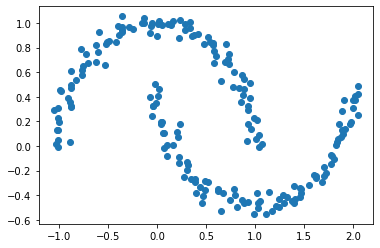

In [5]:
plt.scatter(Y[:,0],Y[:,1])

In [6]:
D = np.zeros([p,p])

In [7]:
for i in range(p):
    for j in range(i):
        D[i,j] = np.sqrt(np.sum((Y[i]-Y[j])**2))
        D[j,i] = D[i,j]

In [8]:
@jit(nopython=True)
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k%ncol

In [9]:
# @jit(nopython=True)
def FindMST(A):
    

    p = A.shape[0]
    MST = np.zeros((p,p))

    Xl = list()
    Vl = list(range(p))
    Xl.append(0)
    Vl.remove(0)

    i = 0
    while len(Vl)>0:
        idx0, idx1 = find_min_idx(A[Xl][:,Vl])

        MST[Xl[idx0],Vl[idx1]]=1

        Xl.append(Vl[idx1])
        Vl.remove(Vl[idx1])

        i+=1
    
    return MST + MST.T

In [10]:
MST = FindMST(D)
mst0 = MST.copy()

In [11]:
def getB(A):
    p = A.shape[0]

    B = np.zeros([p,p-1])

    idx = 0
    for i in range(p):
        for j in range(i):
            if A[i,j]==1:
                B[i,idx]=1
                B[j,idx]=-1
                idx+=1
    return B

In [12]:
@jit(nopython=True)
def getA(B):
    A = - B@B.T
    np.fill_diagonal(A,0)
    return A

In [13]:
A = MST
B = getB(A)

In [14]:
B2Inv = np.linalg.inv(B.T@B)

In [15]:
B2Inv

array([[ 0.995,  0.99 ,  0.98 , ..., -0.01 ,  0.01 , -0.005],
       [ 0.99 ,  1.98 ,  1.96 , ..., -0.02 ,  0.02 , -0.01 ],
       [ 0.98 ,  1.96 ,  3.92 , ..., -0.04 ,  0.04 , -0.02 ],
       ...,
       [-0.01 , -0.02 , -0.04 , ...,  1.98 ,  0.02 , -0.01 ],
       [ 0.01 ,  0.02 ,  0.04 , ...,  0.02 ,  1.98 , -0.99 ],
       [-0.005, -0.01 , -0.02 , ..., -0.01 , -0.99 ,  0.995]])

In [16]:
full_edge_idx = np.arange(p-1)
full_node_idx = np.arange(p)

In [17]:
@jit(nopython=True)
def getSubInverse(B2Inv, k):
        
    sel = full_edge_idx==k
    sel_not = full_edge_idx!=k
    
    M11 = B2Inv[sel_not,][:,sel_not]
    M12 = B2Inv[sel_not,][:,sel]
    M22 = B2Inv[sel,][:,sel]

    return M11 - M12@M12.T/M22[0,0]    

In [18]:
# np.sum((getSubInverse(B2Inv,10) - getSubInverse2(B2Inv,10)  )**2)

In [19]:
s0 = 0.1
s1 = 0.5

In [20]:
sigma = np.ones(p) * s0

slab_indicator = np.random.uniform(0,1,p)<0.1

sigma[slab_indicator]= s1

w = 0.01

In [21]:
i =0


In [22]:
@jit(nopython=True)
def updateSlab(A,s0,s1, w):

    D2A= D**2*A
    
    slab_indicator = np.zeros(p)
    sigma = np.zeros(p)

    for i in range(p):
        choice0 = -np.sum(D2A[i]/2/s0) - np.sum(A[i])*np.log(s0) + np.log(1-w)
        choice1 = -np.sum(D2A[i]/2/s1) - np.sum(A[i])*np.log(s1) + np.log(w)
        slab_indicator[i] = np.argmax(np.array([choice0,choice1])+np.random.gumbel(0,1,2))==1
        if(slab_indicator[i]):
            sigma[i]=s1
        else:
            sigma[i]=s0

    return slab_indicator, sigma

In [23]:
@jit(nopython=True)
def compLogP(D, sigma):
    logP =-(D**2/sigma).T/sigma
    logP = (logP - np.log(sigma)).T- np.log(sigma)
    return logP

In [24]:
@jit(nopython=True)

def findRowColIdx(idx,m1,m2):
    r = int(idx / m2)
    return (r,     idx - r*m2)

In [25]:
B[:,1].T@B[:,1]

2.0

In [26]:
@jit(nopython=True)

def updateB(B, logP, B2Inv):

    full_edge_idx = np.arange(p-1)
    full_node_idx = np.arange(p)

    for k in range(p-1):


        # quick way to compute P_s and update B2inv

        sel = full_edge_idx==k
        sel_not = full_edge_idx!=k
        B_not_s = B[:, sel_not]

        B_not_s2_inv =  getSubInverse(B2Inv,k)
        
        
#         B_not_s2_inv_B_not_s = B_not_s2_inv@B_not_s.T    # complexity O(p^3)
#         P_s = np.eye(p) - B_not_s @ B_not_s2_inv_B_not_s # complexity O(p^3)
#         beta_k = P_s@(B[:,sel])
        
        beta_k =  B[:,sel] -  B_not_s@(B_not_s2_inv@ (B_not_s.T@B[:,sel])) #complexity O(p^2)

#         beta_k = NulSpaceB(B,k)
#         beta_k = np.round(beta_k.flatten(),2)

        beta_k = beta_k.flatten()
        mid_point =  (np.max(beta_k)+np.min(beta_k))/2
    
        subgraph0 = beta_k> mid_point
        subgraph1 = beta_k<= mid_point
        
#         beta_k = np.floor(beta_k.flatten()* 1E10)

#         unique_values = np.unique(beta_k) #list(set(beta_k))

#         if len(unique_values)!=2:
#             print(unique_values)
#             print("error")

#         subgraph0 = beta_k==unique_values[0]
#         subgraph1 = beta_k==unique_values[1]

        subgraph0_node_idx = full_node_idx[subgraph0]
        subgraph1_node_idx = full_node_idx[subgraph1]

        logp_choices =  logP[subgraph0_node_idx,:][:,subgraph1_node_idx]

        m1,m2 = logp_choices.shape
        logp_gumbel = logp_choices + np.random.gumbel(0,1, logp_choices.shape)
        idx = np.argmax(logp_gumbel)

        r_idx, c_idx = findRowColIdx(idx,m1,m2)
        
        
        B_k_vec = (B[:,k]).copy()
        

        new_idx0= subgraph0_node_idx[r_idx]
        new_idx1= subgraph1_node_idx[c_idx]

        B[:,k] = 0
        B[new_idx0,k]=1
        B[new_idx1,k]= - 1
        
        if np.sum(np.abs(B[:,k]- B_k_vec))>0:
        

            # update B2Inv
            B_s_star = B[:,sel]
#             M22_star = 1/(B_s_star.T@P_s@B_s_star) # complexity: O(p^3)
            b = B_not_s.T@B_s_star # complexity: O(p^2)
            B_invB_b = B_not_s2_inv@b # complexity: O(p^2)
            M22_star = 1./(2.0 -  b.T@(B_invB_b))
    


#             M12_star= - B_not_s2_inv_B_not_s@B_s_star * M22_star
            M12_star= - B_invB_b * M22_star



            M11_star = B_not_s2_inv+M12_star@M12_star.T/M22_star

            temp = B2Inv[sel_not]
            temp[:,sel_not] = M11_star
            temp[:,sel] = M12_star
            B2Inv[sel_not] = temp


            temp = B2Inv[sel]
            temp[:,sel_not] = M12_star.T
            temp[:,sel]=M22_star
            B2Inv[sel]= temp

    return [B,B2Inv]

In [27]:
import copy

In [28]:
A_trace = list()

In [29]:
logP =  compLogP(D,sigma)

slab_indicator, sigma = updateSlab(A,s0,s1,w)

# B, B2Inv = updateB(B, logP, B2Inv)

In [30]:
import time



In [31]:

start = time.time()


for k in range(1000):
    
    logP =  compLogP(D,sigma)
    
    slab_indicator, sigma = updateSlab(A,s0,s1,w)
    
    B, B2Inv = updateB(B, logP, B2Inv)
    A = getA(B)

    A_trace.append(A.copy())
    
    if (k+1) % 100==0:
        print(k)
        
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

    
#     print(np.abs(A-mst0).sum())

99
199
299
399
499
599
699
799
899
999
Elapsed (with compilation) = 105.95705771446228


In [32]:
np.max(np.abs(np.linalg.inv(B.T@B)- B2Inv))

1.786979453299864e-09

In [33]:
print(np.abs(A-mst0).sum())

464.0


In [34]:
mst_trace_arr = np.array(A_trace)

In [35]:
mean_mst = mst_trace_arr.mean(0)

In [36]:
# plt.plot(mst_trace_arr[:100,96,97])

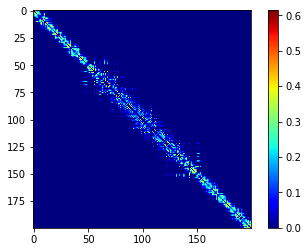

In [37]:
plt.imshow(mean_mst, vmin=0,cmap='jet')
plt.colorbar()

In [38]:
import igraph

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

In [40]:
c_vec = ['lightblue']*50
# c_vec[3] = 'red'
# c_vec[2] = 'yellow'
# c_vec[4] = 'purple'


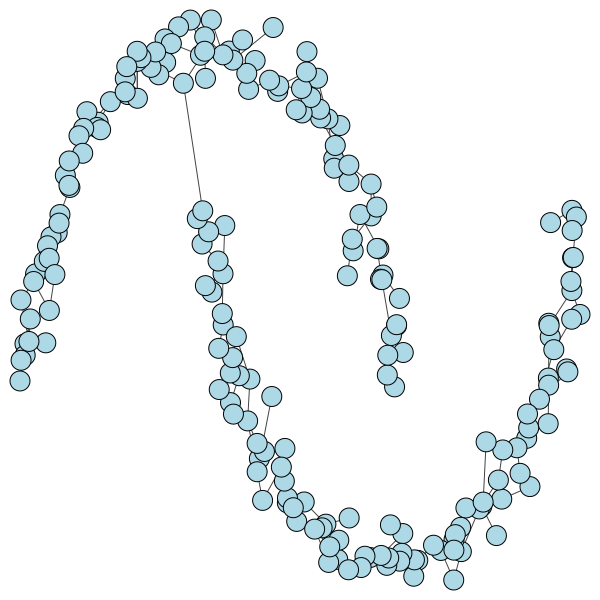

In [41]:
a= mst_trace_arr[200]
np.fill_diagonal(a,0)
a= a.round()

g = igraph.Graph.Adjacency((a > 0).tolist())
g.to_undirected()

layout = zip(list(-Y[:,0]), list(Y[:,1])) 
out =  igraph.plot(g, layout = layout, vertex_color = c_vec)

# out.save('2moon_tree1.png')
out